In [1]:
# 各種インポート
import os 
import sys
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression #線形回帰のライブラリ
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [2]:
# 交差検証
def cross_validation(data, target, clf, n_split):
    cross_valid_mse,cross_valid_rmse, cross_valid_mae = 0,0,0
    
    for train, test in KFold(n_splits=n_split, shuffle=True, random_state=111).split(data, target):
        data_train, target_train = data.iloc[train], target[train]
        data_test, target_test = data.iloc[test], target[test]
        clf.fit(data_train, target_train)

        predicted_target = clf.predict(data_test)
        
         # 平均二乗誤差 (MSE)
        cross_valid_mse += metrics.mean_squared_error(target_test, predicted_target)
        # 二乗平均平方根誤差 (RMSE)
        cross_valid_rmse += np.sqrt(metrics.mean_squared_error(target_test, predicted_target))
        # 平均絶対誤差 (MAE)
        cross_valid_mae += metrics.mean_absolute_error(target_test, predicted_target)
    mse = cross_valid_mse / n_split
    rmse = cross_valid_rmse / n_split
    mae = cross_valid_mae / n_split
    return {"MSE":mse, "RMSE":rmse, "MAE":mae}

### csvファイルの読み込み

In [3]:
df = pd.read_csv("measurements.csv")

#### 説明変数を数値化するため、ダミー変数を使用

In [4]:
df = pd.get_dummies(df)

In [5]:
# 係数を求める
y = df["consume"]
X = df.loc[:,["distance","speed","gas_type_E10","gas_type_SP98"]]
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]

# 変数の設定
x1 = df["distance"].values
x2 = df["speed"].values
x3 = df["gas_type_E10"].values
x4 = df["gas_type_SP98"].values
y = df["consume"].values

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2 + x3*w3 + x4*w4 
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, 二乗誤差 = {:.3f}'.format(w0, w1, w2,w3,w4,squared_error))

w0 = 5.656, w1 = -0.000, w2 = -0.018, w3 = 0.040, w4 = -0.040, 二乗誤差 = 195.532


In [6]:
# 予測値
y_est

array([5.23800802, 5.16867382, 5.02836806, 5.06336578, 4.88763723,
       4.81799864, 4.94082916, 4.9932234 , 5.23922029, 5.16867907,
       4.95813122, 5.02833658, 4.65989752, 4.67679025, 4.88795735,
       5.27365648, 5.06228996, 5.13359738, 5.01005315, 4.99324964,
       5.13288891, 5.02821063, 5.04555992, 5.06342351, 4.60726712,
       4.69497921, 5.32622916, 5.20342489, 5.18588667, 5.08062062,
       4.80024526, 5.18622778, 4.67744099, 4.99215808, 5.06304566,
       5.06340777, 5.04544971, 5.23922029, 5.29148859, 4.67744099,
       4.73006614, 5.18661088, 5.04588529, 4.92315974, 5.05455409,
       5.24771066, 5.05409227, 5.17680208, 5.17702249, 4.98323092,
       5.10684862, 4.5104337 , 4.54546816, 4.80854145, 5.12469122,
       4.16960857, 5.19456596, 4.54543143, 4.61560005, 4.70332263,
       5.30029383, 5.21261847, 5.19467092, 5.15974142, 5.19453447,
       4.61560005, 4.89632701, 4.65069223, 4.91375503, 4.96650088,
       4.65069223, 5.26525412, 5.10673842, 4.87889375, 5.17703

In [7]:
# 誤差の計算
mse = mean_squared_error(y,y_est)
print("二乗誤差（MSE） = %s"%round(mse,3))

mae = mean_absolute_error(y,y_est)
print("平方根二乗誤差（RMSE) = %s"%round(mae,3))

rmse = np.sqrt(mse)
print("絶対値誤差（MAE） = %s"%round(rmse,3))

二乗誤差（MSE） = 1.008
平方根二乗誤差（RMSE) = 0.68
絶対値誤差（MAE） = 1.004


In [8]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X.loc[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X.loc[test_idx], y[test_idx]
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.711

Fold 2
MAE = 0.687

Fold 3
MAE = 0.799

Fold 4
MAE = 0.68

Fold 5
MAE = 0.586

Cross Validation MAE = 0.693


## 【Ridge】
今回は説明変数が元々4つと少ないため、Ridgeを採用している<br>
Lassoでは説明変数を無くす処理なので、これ以上説明変数を削減するのは適切ではないと感じた<br>
しかし、その判断は直観的であるので、明確な理由などはない。


### 正則化項ありで係数を推定する

In [9]:
alpha = [1e-8]
est = LinearRegression(Ridge(alpha=alpha,fit_intercept=True,max_iter=1000,tol=0.0001,random_state=1234))
est.fit(X, y)
est = est.predict(X)
est


array([5.23800802, 5.16867382, 5.02836806, 5.06336578, 4.88763723,
       4.81799864, 4.94082916, 4.9932234 , 5.23922029, 5.16867907,
       4.95813122, 5.02833658, 4.65989752, 4.67679025, 4.88795735,
       5.27365648, 5.06228996, 5.13359738, 5.01005315, 4.99324964,
       5.13288891, 5.02821063, 5.04555992, 5.06342351, 4.60726712,
       4.69497921, 5.32622916, 5.20342489, 5.18588667, 5.08062062,
       4.80024526, 5.18622778, 4.67744099, 4.99215808, 5.06304566,
       5.06340777, 5.04544971, 5.23922029, 5.29148859, 4.67744099,
       4.73006614, 5.18661088, 5.04588529, 4.92315974, 5.05455409,
       5.24771066, 5.05409227, 5.17680208, 5.17702249, 4.98323092,
       5.10684862, 4.5104337 , 4.54546816, 4.80854145, 5.12469122,
       4.16960857, 5.19456596, 4.54543143, 4.61560005, 4.70332263,
       5.30029383, 5.21261847, 5.19467092, 5.15974142, 5.19453447,
       4.61560005, 4.89632701, 4.65069223, 4.91375503, 4.96650088,
       4.65069223, 5.26525412, 5.10673842, 4.87889375, 5.17703

In [10]:
# 誤差の計算
mse = mean_squared_error(y,est)
print("二乗誤差（MSE） = %s"%round(mse,3))

mae = mean_absolute_error(y,est)
print("平方根二乗誤差（RMSE) = %s"%round(mae,3))

rmse = np.sqrt(mse)
print("絶対値誤差（MAE） = %s"%round(rmse,3))

二乗誤差（MSE） = 1.008
平方根二乗誤差（RMSE) = 0.68
絶対値誤差（MAE） = 1.004


### ホールドアウト法を適用し予測の精度を測る

In [11]:
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
alpha = [1e-8]#alpha(数式ではλ)の値を4つ指定する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
est = LinearRegression(Ridge(alpha=alpha,fit_intercept=True,max_iter=1000,tol=0.0001,random_state=1234))
est = est.fit(X_train, y_train)
y_pred_train = est.predict(X_train)

In [12]:
# 学習データに対するMAEを計算（訓練誤差の評価）
mse = mean_squared_error(y_train, y_pred_train)
print("二乗誤差（MSE） = %s"%round(mse,3))

mae = mean_absolute_error(y_train, y_pred_train)
print("平方根二乗誤差（RMSE) = %s"%round(mae,3))

rmse = np.sqrt(mse)
print("絶対値誤差（MAE） = %s"%round(rmse,3))

二乗誤差（MSE） = 1.086
平方根二乗誤差（RMSE) = 0.683
絶対値誤差（MAE） = 1.042


### 交差検証法を用いて汎化誤差を評価する

In [13]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

test_size = 0.2
alpha = [1e-8]


est = LinearRegression(Ridge(alpha=alpha,fit_intercept=True,max_iter=1000,tol=0.0001,random_state=1234))
est = est.fit(X,y)
y_pred = est.predict(X)

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y_pred):
    X_train, y_train = X.loc[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X.loc[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.711

Fold 2
MAE = 0.687

Fold 3
MAE = 0.799

Fold 4
MAE = 0.68

Fold 5
MAE = 0.586

Cross Validation MAE = 0.693


In [14]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

test_size = 0.2
alpha = [1e-8]


# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X.loc[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X.loc[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    est = LinearRegression(Ridge(alpha=alpha,fit_intercept=True,max_iter=1000,tol=0.0001,random_state=1234))
    est = est.fit(X_train,y_train)

    # テストデータに対する予測を実行
    y_pred_train = est.predict(X_train)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_train, y_pred_train)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.683

Fold 2
MAE = 0.693

Fold 3
MAE = 0.631

Fold 4
MAE = 0.684

Fold 5
MAE = 0.709

Cross Validation MAE = 0.68


In [15]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

test_size = 0.2
alpha = [1e-8]

for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X.loc[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X.loc[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    est = LinearRegression(Ridge(alpha=alpha,fit_intercept=True,max_iter=1000,tol=0.0001,random_state=1234))
    est = est.fit(X_train,y_train)
    
    y_pred_train = est.predict(X_train)
    
    mae = mean_absolute_error(y_train,y_pred_train)
    
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1
    
# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.683

Fold 2
MAE = 0.693

Fold 3
MAE = 0.631

Fold 4
MAE = 0.684

Fold 5
MAE = 0.709

Cross Validation MAE = 0.68


In [16]:
clf = linear_model.LinearRegression(fit_intercept=True)

target = df["consume"]
data = df.loc[:,["distance","speed","gas_type_E10","gas_type_SP98"]]

In [17]:
# そのまま
as_it_is = cross_validation(data, target, clf, 50)
print(as_it_is)

{'MSE': 1.0180865278084712, 'RMSE': 0.8940839584972947, 'MAE': 0.685247900260134}


In [18]:
# 標準化
std_data = (data - data.mean()) / data.std()
std = cross_validation(std_data, target, clf, 50)
print(std)

{'MSE': 1.0180743364250053, 'RMSE': 0.8940774151733066, 'MAE': 0.6854038942866759}


In [19]:
# 0~1に正規化
normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
normalize = cross_validation(normalized_data, target, clf, 50)
print(normalize)

{'MSE': 1.0180134191878676, 'RMSE': 0.8940257603634284, 'MAE': 0.6851129964303568}


In [20]:
data

,distance,speed,gas_type_E10,gas_type_SP98
0,28.0,26,1,0
1,12.0,30,1,0
2,11.2,38,1,0
3,12.9,36,1,0
4,18.5,46,1,0
5,8.3,50,1,0
6,7.8,43,1,0
7,12.3,40,1,0
8,4.9,26,1,0
9,11.9,30,1,0


In [21]:
# 正則化項のグリッドサーチ
def crossvalidation_with_gridsearch(data, target, n_split, lasso_or_ridge, range_searching_list):
    result_list = []
    for alpha in range_searching_list:
        if lasso_or_ridge == "lasso":
            clf = linear_model.Lasso(alpha=alpha, fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
        elif lasso_or_ridge == "ridge":
            clf = linear_model.Ridge(alpha=alpha, fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
        result = cross_validation(data, target, clf, n_split)
        result_list.append([alpha, result['RMSE']])
        print(alpha, result) # 経過が見たかったらコメントをはずす
    sorted_result_list = sorted(result_list, key=lambda x: x[1])
    print("RMSE最小のalpha", sorted_result_list[0][0])
    
    if lasso_or_ridge == "lasso":
        clf = linear_model.Lasso(alpha=sorted_result_list[0][0], fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
    elif lasso_or_ridge == "ridge":
        clf = linear_model.Ridge(alpha=sorted_result_list[0][0], fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
    
    return cross_validation(data, target, clf, n_split)

In [22]:
target = df["consume"]
data = df[["distance","speed","gas_type_E10","gas_type_SP98"]]


# L1正則化

range_searching_list = np.arange(0.01, 2.01, 0.01)

# そのまま
ridge = crossvalidation_with_gridsearch(data, target, 50, "ridge", range_searching_list)
# 標準化
std_ridge= crossvalidation_with_gridsearch(std_data, target, 50, "ridge", range_searching_list)
# 0~1に正規化
normalized_ridge = crossvalidation_with_gridsearch(normalized_data, target, 50, "ridge", range_searching_list)

0.01 {'MSE': 1.0180862661918098, 'RMSE': 0.894083887361991, 'MAE': 0.6852478102943482}
0.02 {'MSE': 1.0180860046131608, 'RMSE': 0.8940838162398572, 'MAE': 0.6852477203379315}
0.03 {'MSE': 1.0180857430725185, 'RMSE': 0.8940837451308893, 'MAE': 0.6852476303908819}
0.04 {'MSE': 1.0180854815698728, 'RMSE': 0.8940836740350855, 'MAE': 0.6852475404531982}
0.05 {'MSE': 1.018085220105217, 'RMSE': 0.8940836029524425, 'MAE': 0.6852474505248795}
0.060000000000000005 {'MSE': 1.018084958678543, 'RMSE': 0.894083531882957, 'MAE': 0.6852473606059228}
0.06999999999999999 {'MSE': 1.0180846972898439, 'RMSE': 0.8940834608266254, 'MAE': 0.6852472706963282}
0.08 {'MSE': 1.0180844359391108, 'RMSE': 0.8940833897834449, 'MAE': 0.685247180796093}
0.09 {'MSE': 1.0180841746263358, 'RMSE': 0.8940833187534125, 'MAE': 0.6852470909052165}
0.09999999999999999 {'MSE': 1.0180839133515125, 'RMSE': 0.8940832477365248, 'MAE': 0.6852470010236962}
0.11 {'MSE': 1.018083652114632, 'RMSE': 0.8940831767327795, 'MAE': 0.6852469111

0.92 {'MSE': 1.0180626172238367, 'RMSE': 0.8940774687896547, 'MAE': 0.6852396624332309}
0.93 {'MSE': 1.018062359071953, 'RMSE': 0.8940773988530499, 'MAE': 0.6852395733229604}
0.9400000000000001 {'MSE': 1.0180621009573734, 'RMSE': 0.8940773289293328, 'MAE': 0.685239484221918}
0.9500000000000001 {'MSE': 1.0180618428800894, 'RMSE': 0.8940772590184991, 'MAE': 0.685239395130102}
0.9600000000000001 {'MSE': 1.0180615848400922, 'RMSE': 0.8940771891205468, 'MAE': 0.6852393060475115}
0.97 {'MSE': 1.0180613268373762, 'RMSE': 0.8940771192354715, 'MAE': 0.6852392169741441}
0.98 {'MSE': 1.0180610688719327, 'RMSE': 0.8940770493632723, 'MAE': 0.6852391279099989}
0.99 {'MSE': 1.0180608109437541, 'RMSE': 0.8940769795039439, 'MAE': 0.6852390388550741}
1.0 {'MSE': 1.0180605530528337, 'RMSE': 0.8940769096574848, 'MAE': 0.6852389498093682}
1.01 {'MSE': 1.0180602951991617, 'RMSE': 0.8940768398238919, 'MAE': 0.6852388607728797}
1.02 {'MSE': 1.0180600373827329, 'RMSE': 0.8940767700031614, 'MAE': 0.685238771745

1.84 {'MSE': 1.0180390224497722, 'RMSE': 0.8940710881884735, 'MAE': 0.6852315027274145}
1.85 {'MSE': 1.0180387676981153, 'RMSE': 0.8940710194248821, 'MAE': 0.6852314144598165}
1.86 {'MSE': 1.0180385129830676, 'RMSE': 0.8940709506739016, 'MAE': 0.6852313262013087}
1.87 {'MSE': 1.0180382583046232, 'RMSE': 0.8940708819355304, 'MAE': 0.6852312379518888}
1.8800000000000001 {'MSE': 1.0180380036627736, 'RMSE': 0.894070813209764, 'MAE': 0.6852311497115561}
1.8900000000000001 {'MSE': 1.0180377490575114, 'RMSE': 0.894070744496601, 'MAE': 0.6852310614803089}
1.9000000000000001 {'MSE': 1.0180374944888302, 'RMSE': 0.8940706757960374, 'MAE': 0.6852309732581454}
1.9100000000000001 {'MSE': 1.0180372399567215, 'RMSE': 0.8940706071080702, 'MAE': 0.6852308850450646}
1.9200000000000002 {'MSE': 1.018036985461178, 'RMSE': 0.8940705384326968, 'MAE': 0.6852307968410645}
1.93 {'MSE': 1.0180367310021932, 'RMSE': 0.8940704697699147, 'MAE': 0.685230708646144}
1.94 {'MSE': 1.0180364765797583, 'RMSE': 0.89407040111

0.74 {'MSE': 1.0180527755622628, 'RMSE': 0.8940224374816432, 'MAE': 0.685173742900719}
0.75 {'MSE': 1.0180523247151647, 'RMSE': 0.8940216107652804, 'MAE': 0.6851727433728267}
0.76 {'MSE': 1.0180518740075089, 'RMSE': 0.8940207841721666, 'MAE': 0.685171743913989}
0.77 {'MSE': 1.0180514234392584, 'RMSE': 0.894019957702273, 'MAE': 0.6851707445241978}
0.78 {'MSE': 1.0180509730103755, 'RMSE': 0.8940191313555715, 'MAE': 0.6851697452034428}
0.79 {'MSE': 1.018050522720825, 'RMSE': 0.8940183051320344, 'MAE': 0.6851687459517148}
0.8 {'MSE': 1.0180500725705681, 'RMSE': 0.8940174790316331, 'MAE': 0.6851677467690047}
0.81 {'MSE': 1.0180496225595697, 'RMSE': 0.89401665305434, 'MAE': 0.6851667476553025}
0.8200000000000001 {'MSE': 1.018049172687792, 'RMSE': 0.8940158272001263, 'MAE': 0.6851657486105993}
0.8300000000000001 {'MSE': 1.0180487229551987, 'RMSE': 0.8940150014689646, 'MAE': 0.6851647496348854}
0.8400000000000001 {'MSE': 1.0180482733617524, 'RMSE': 0.8940141758608265, 'MAE': 0.6851637507281515

1.6600000000000001 {'MSE': 1.0180118767364918, 'RMSE': 0.8939468919849359, 'MAE': 0.6850820742199617}
1.6700000000000002 {'MSE': 1.0180114385652157, 'RMSE': 0.8939460764907252, 'MAE': 0.6850810810058792}
1.68 {'MSE': 1.0180110005300405, 'RMSE': 0.8939452611172102, 'MAE': 0.6850800878599912}
1.69 {'MSE': 1.0180105626309284, 'RMSE': 0.8939444458643641, 'MAE': 0.6850790947822891}
1.7 {'MSE': 1.018010124867845, 'RMSE': 0.893943630732158, 'MAE': 0.685078101772763}
1.71 {'MSE': 1.0180096872407545, 'RMSE': 0.8939428157205657, 'MAE': 0.6850771088314039}
1.72 {'MSE': 1.0180092497496205, 'RMSE': 0.8939420008295597, 'MAE': 0.6850761159582025}
1.73 {'MSE': 1.018008812394409, 'RMSE': 0.8939411860591123, 'MAE': 0.6850751231531494}
1.74 {'MSE': 1.0180083751750815, 'RMSE': 0.8939403714091969, 'MAE': 0.6850741304162358}
1.75 {'MSE': 1.018007938091605, 'RMSE': 0.8939395568797854, 'MAE': 0.6850731377474518}
1.76 {'MSE': 1.018007501143942, 'RMSE': 0.8939387424708513, 'MAE': 0.685072145146789}
1.77 {'MSE':

0.5700000000000001 {'MSE': 1.0170375078916445, 'RMSE': 0.8924536228088459, 'MAE': 0.6834673914361628}
0.5800000000000001 {'MSE': 1.0170238086597079, 'RMSE': 0.89242863352429, 'MAE': 0.6834386397424148}
0.59 {'MSE': 1.0170102448105314, 'RMSE': 0.8924037503480343, 'MAE': 0.6834099514699089}
0.6 {'MSE': 1.0169968152390603, 'RMSE': 0.8923789725174974, 'MAE': 0.683381326284353}
0.61 {'MSE': 1.0169835188539345, 'RMSE': 0.8923542992794211, 'MAE': 0.6833527638547138}
0.62 {'MSE': 1.0169703545772553, 'RMSE': 0.8923297298897168, 'MAE': 0.6833242638531732}
0.63 {'MSE': 1.0169573213443563, 'RMSE': 0.8923052636133096, 'MAE': 0.6832958259550859}
0.64 {'MSE': 1.0169444181035807, 'RMSE': 0.8922808997239821, 'MAE': 0.683267449838933}
0.65 {'MSE': 1.0169316438160605, 'RMSE': 0.8922566375042286, 'MAE': 0.6832391351862842}
0.66 {'MSE': 1.0169189974555048, 'RMSE': 0.8922324762451064, 'MAE': 0.6832108816817539}
0.67 {'MSE': 1.0169064780079895, 'RMSE': 0.8922084152460951, 'MAE': 0.6831826890129598}
0.68 {'MS

1.48 {'MSE': 1.0162392918185639, 'RMSE': 0.8905407121629577, 'MAE': 0.6811469770565399}
1.49 {'MSE': 1.016234595711273, 'RMSE': 0.8905230784673458, 'MAE': 0.6811240833918023}
1.5 {'MSE': 1.0162299712930343, 'RMSE': 0.8905055065701873, 'MAE': 0.6811012302950425}
1.51 {'MSE': 1.0162254181309234, 'RMSE': 0.8904879961659978, 'MAE': 0.6810784176152193}
1.52 {'MSE': 1.0162209357956775, 'RMSE': 0.8904705469517805, 'MAE': 0.6810556452023433}
1.53 {'MSE': 1.0162165238616572, 'RMSE': 0.8904531586269953, 'MAE': 0.6810329129074627}
1.54 {'MSE': 1.0162121819068002, 'RMSE': 0.8904358308935285, 'MAE': 0.6810102205826557}
1.55 {'MSE': 1.0162079095125767, 'RMSE': 0.8904185634556641, 'MAE': 0.6809875680810176}
1.56 {'MSE': 1.0162037062639526, 'RMSE': 0.8904013560200554, 'MAE': 0.6809649552566513}
1.57 {'MSE': 1.0161995717493415, 'RMSE': 0.8903842082956963, 'MAE': 0.6809429340211938}
1.58 {'MSE': 1.0161955055605671, 'RMSE': 0.8903671199938928, 'MAE': 0.6809211179658583}
1.59 {'MSE': 1.0161915072928245, '

In [23]:
ridge_mse_list = [ridge['MSE'], std_ridge['MSE'], normalized_ridge['MSE']]
ridge_rmse_list = [ridge['RMSE'], std_ridge['RMSE'], normalized_ridge['RMSE']]
ridge_mae_list = [ridge['MAE'], std_ridge['MAE'], normalized_ridge['MAE']]

result = pd.DataFrame([ridge_mse_list, ridge_rmse_list, ridge_mae_list], index=["MSE", "RMSE", "MAE"]).T
result.index = ["そのまま","標準化","正規化"]
display(result)

,MSE,RMSE,MAE
そのまま,1.018035,0.894070,0.685230
標準化,1.017997,0.893919,0.685048
正規化,1.016081,0.889700,0.680074


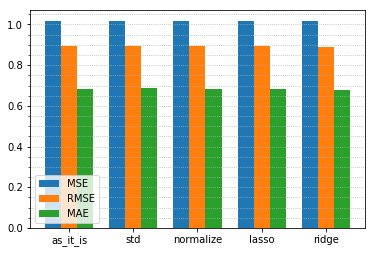

In [24]:
# 手法ごとに精度を描画
mse_list = [as_it_is['MSE'], std['MSE'], normalize['MSE'], std_ridge['MSE'], normalized_ridge['MSE']]
rmse_list = [as_it_is['RMSE'], std['RMSE'], normalize['RMSE'], std_ridge['RMSE'], normalized_ridge['RMSE']]
mae_list = [as_it_is['MAE'], std['MAE'], normalize['MAE'], std_ridge['MAE'], normalized_ridge['MAE']]
 
left = np.arange(len(mse_list))
labels = ['as_it_is', 'std', 'normalize', 'lasso', 'ridge']

width = 0.25
 
plt.bar(left, mse_list, width=width, align='center', label="MSE")
plt.bar(left+width, rmse_list, width=width, align='center', label="RMSE")
plt.bar(left+width*2, mae_list, width=width, align='center', label="MAE")

plt.legend(loc='lower left')
plt.xticks(left + width, labels)
plt.gca().yaxis.set_minor_locator(tick.MultipleLocator(0.05))
plt.grid(linestyle='dotted', which='minor')
plt.show()

In [25]:
# 精度の表
result = pd.DataFrame([mse_list, rmse_list, mae_list], index=["MSE", "RMSE", "MAE"]).T
result.index = ["そのまま","標準化","正規化", "L1正則化", "L2正則化"]
pd.options.display.precision = 16
display(result)

,MSE,RMSE,MAE
そのまま,1.0180865278084712,0.8940839584972947,0.6852479002601340
標準化,1.0180743364250053,0.8940774151733066,0.6854038942866759
正規化,1.0180134191878676,0.8940257603634284,0.6851129964303568
L1正則化,1.0179970550517012,0.8939192327286942,0.6850483431430733
L2正則化,1.0160814759909200,0.8896995570296192,0.6800744336455263


In [26]:
# それぞれの指標での最小値とその手法
pd.concat([result.idxmin(), result.min()], axis=1)

,0,1
MSE,L2正則化,1.0160814759909200
RMSE,L2正則化,0.8896995570296192
MAE,L2正則化,0.6800744336455263
